# Introduction 


This notebook will not run in **`binder`**. It processes a fairly large dataset external
to the repository. The output results are however part of the repository and are therefore
available to the other notebooks: See subfolder `profiles`. It contains `.csv` files that 
delineate profile timing. Each row is a profile from start of ascent to descent to end
of rest interval. 


The profile scanning done in this notebook covers three sites of interest: 
Axial Base, Oregon Slope Base and Oregon Offshore
(part of the Endurance array). These sites are abbreviated respectively
*axb*, *osb* and *oos*.


The years of interest are 2015 through August 2021.


Note that this Jupyter notebook is strictly about creating metadata for subsequent analysis of 
water column profiles with various sensors. The sensor data have been cleaned up in the prior
(Ocean 01 C) notebook.


The following cell is utility Python configuration.


In [1]:
import os, sys, time, glob, warnings
from IPython.display import clear_output             # use inside loop with clear_output(wait = True) followed by print(i)
warnings.filterwarnings('ignore')
this_dir = os.getcwd()
data_dir = this_dir + '/../../data'                  # large datasets reside outside the repository

from matplotlib import pyplot as plt
from matplotlib import colors as mplcolors
import numpy as np, pandas as pd, xarray as xr
from numpy import datetime64 as dt64, timedelta64 as td64

# convenience functions abbreviating 'datetime64' and so on
def doy(theDatetime): return 1 + int((theDatetime - dt64(str(theDatetime)[0:4] + '-01-01')) / td64(1, 'D'))
def dt64_from_doy(year, doy): return dt64(str(year) + '-01-01') + td64(doy-1, 'D')
def day_of_month_to_string(d): return str(d) if d > 9 else '0' + str(d)

print('\nJupyter Notebook running Python {}'.format(sys.version_info[0]))


Jupyter Notebook running Python 3


## This notebook's "to do" list


* Annotate pH equil stops: both local midnight and noon
    * Are things like T/C/DO stable during equil stops?      
* Does chlorophyll versus backscatter show more zooplankton at depth? Diel?
    * ArcticGRO 29
* `class Profile`

```
class Profile:
    """A water column profile"""
    
    def __init__(self, t0='2019-01-01T00:26:05', t1='2019-01-01T01:37:55', d0=191.268063, d1=6.618323, site='osb'):
        self.t0 = dt64(t0)
        self.t1 = dt64(t1)
        self.d0 = d0
        self.d1 = d1
        self.site = site

    def readout(self):
        print("Profile start", self.t0, 'duration', self.t1 - self.t0)

p = Profile()
p.readout()
```

In [2]:
def ProfileCrawler(s, t, verbose = False):
    """
    ProfileCrawler traverses a passed pandas Series s of pressures and Series t of corresponding times.
    The code is designed for data sampled at about 1-minute intervals. Goal: Determine profiler activity 
    timestamps. Results are returned as a tuple of six lists:  
        Start and end times for ascent, descent and rest intervals.
    """

    # pandas series, just pressures
    len_s = len(s)
    threshold = 1.
    a0, d0, r0 = [], [], []               # start times for ascents, descents, rests

    for i in range(1, len_s - 5):         # 6 minute window
        
        # catch ascent
        if s[i-1] - s[i]   <= threshold and  \
           s[i]   - s[i+1] >= threshold and  \
           s[i+1] - s[i+2] >= threshold and  \
           s[i+2] - s[i+3] >= threshold and  \
           s[i+3] - s[i+4] >= threshold and  \
           s[i+4] - s[i+5] >= threshold:
            a0.append((i,t[i]))

        # catch descent
        if s[i-1] - s[i]   >= threshold and  \
           s[i]   - s[i+1] <= threshold and  \
           s[i+1] - s[i+2] <= threshold and  \
           s[i+2] - s[i+3] <= threshold and  \
           s[i+3] - s[i+4] <= threshold and  \
           s[i+4] - s[i+5] <= threshold:
            d0.append((i,t[i]))

        # this variant is a little too liberal; false positives ~25%
        # why? Because twice daily there are stops on the way down for pH
        # catch rest
        if i >= 5 and \
           s[i-5] - s[i-4] <= -threshold and  \
           s[i-4] - s[i-3] <= -threshold and  \
           s[i-3] - s[i-2] <= -threshold and  \
           s[i-2] - s[i-1] <= -threshold and  \
           s[i-1] - s[i]   <= -threshold and  \
           s[i]   - s[i+1] >= -threshold:
            r0.append((i,t[i]))

            
    if verbose: print("there are", len(a0), "ascent starts")
    if verbose: print("there are", len(d0), "descent starts")
    if verbose: print("there are", len(r0), "rest starts: now culling extras")

    # keep running the "rest start" list looking for...
    #     ...relative to this particular rest start...
    #     ...a future rest start earlier than the next ascent start
    #         ...if found: delete this particular rest start...
    #             ...and begin again at the top
    # this winnows away false positive rest starts
    while True: 
        profile_counter = 1               
        for i in range(len(r0)-1):
            if profile_counter >= len(a0) - 1: break
            if r0[i+1][1] < a0[profile_counter][1]: 
                r0.remove(r0[i])
                break
            else: profile_counter += 1
        if profile_counter >= len(a0) - 1: break


    if verbose: print("there are", len(a0), "ascent starts")
    if verbose: print("there are", len(d0), "descent starts")
    if verbose: print("there are", len(r0), "rest starts")
                   
    a1 = d0.copy()             # ascent end = descent start
    d1 = r0.copy()             # descent end = rest start
    r1 = a0[1:].copy()         # rest end = next ascent start (cuts off end of year)
       
    # logic check on results
    causal_errors = [0]*3                 # list [0, 0, 0] tracks 3 types of possible error
    smallest = len(a0)
    if len(d0) < smallest: smallest = len(d0)
    if len(r0) < smallest: smallest = len(r0)
    for i in range(smallest):
        if a0[i][0] >= d0[i][0]: causal_errors[0] += 1    # ascent start later than descent start
        if d0[i][0] >= r0[i][0]: causal_errors[1] += 1    # descent start later than rest start
        if a1[i][0] >= d1[i][0]: causal_errors[2] += 1    # ascent end later than descent end (???)
   
    if verbose: print("causal error counts:", causal_errors[0], causal_errors[1], causal_errors[2])
    if verbose: print(len(a0), len(d0), len(r0))

    # Returning lists of tuples: (index, time)
    return a0, a1, d0, d1, r0, r1


def PrintProfileStatistics(a0, a1, d0, d1, r0, r1):
    """ 
    PrintProfileStatistics prints mean and standard deviation for a set of profiles.
    Specifically for a set of Ascents, Descents and Rests. Each passed vector (a0 etc) 
    is a list of tuples. The first element of the tuple is the index of the time in the 
    source data array. The second value is the timestamp for that same element. 
    """
    one_sec = np.timedelta64(1, 's')
    D_asc  = [(dt64(a1[i][1])-dt64(a0[i][1]))/one_sec for i in range(len(a1))]
    D_dsc  = [(dt64(d1[i][1])-dt64(d0[i][1]))/one_sec for i in range(len(d1))]
    D_rst  = [(dt64(r1[i][1])-dt64(r0[i][1]))/one_sec for i in range(len(r1))]

    print('Means, standard deviation for profile phases, in minutes:')
    print('  Ascents:  ', round(np.mean(D_asc)/60., 2), round(np.std(D_asc)/60., 2))
    print('  Descents: ', round(np.mean(D_dsc)/60., 2), round(np.std(D_dsc)/60., 2))
    print('  Rests:    ', round(np.mean(D_rst)/60., 2), round(np.std(D_rst)/60., 2))
    print()
    print('(Recall that two profiles of nine each day have slower, staged descents)')
    print()
    

def PrintProfileEntry(profile):
    """
    A profile is a list of 12 values as six pairs of (index, timestamp) interleaved values
      ascent start:  index, timestamp
      ascent end:    index, timestamp 
      descent start: index, timestamp 
      descent end:   index, timestamp
      rest start:    index, timestamp
      rest end:      index, timestamp
    The indices refer back to the source dataset, likely at 1Min samples. They could be abolished.
    The file that is written from these pre-pends a counter column; so it has 13 columns total.
    """
    print("ascent:  index / start time:", profile[0], profile[1], '       index / end time:', profile[2], profile[3])
    print("descent: index / start time:", profile[4], profile[5], '       index / end time:', profile[6], profile[7])
    print("rest:    index / start time:", profile[8], profile[9], '       index / end time:', profile[10], profile[11])

    
    
def CompareShallowProfilerTimestamps(a0_dx, a1_dx, d0_dx, d1_dx, r0_dx, r1_dx):
    """
    Using vertical shifts plot the comparative timestamp vectors; y-axis is record index
    """

    from operator import add

    day_td64 = pd.to_timedelta(1, unit='D')

    dt_a0_dx, ind_a0_dx = [(a0_dx[i][1]-a0_dx[0][1])/day_td64 for i in range(len(a0_dx))], []
    for i in range(len(a0_dx)): ind_a0_dx.append(a0_dx[i][0])
    dt_a1_dx, ind_a1_dx = [(a1_dx[i][1]-a1_dx[0][1])/day_td64 for i in range(len(a1_dx))], []
    for i in range(len(a1_dx)): ind_a1_dx.append(a1_dx[i][0])

    dt_d0_dx, ind_d0_dx = [(d0_dx[i][1]-d0_dx[0][1])/day_td64 for i in range(len(d0_dx))], []
    for i in range(len(d0_dx)): ind_d0_dx.append(d0_dx[i][0])
    dt_d1_dx, ind_d1_dx = [(d1_dx[i][1]-d1_dx[0][1])/day_td64 for i in range(len(d1_dx))], []
    for i in range(len(d1_dx)): ind_d1_dx.append(d1_dx[i][0])

    dt_r0_dx, ind_r0_dx = [(r0_dx[i][1]-r0_dx[0][1])/day_td64 for i in range(len(r0_dx))], []
    for i in range(len(r0_dx)): ind_r0_dx.append(r0_dx[i][0])
    dt_r1_dx, ind_r1_dx = [(r1_dx[i][1]-r1_dx[0][1])/day_td64 for i in range(len(r1_dx))], []
    for i in range(len(r1_dx)): ind_r1_dx.append(r1_dx[i][0])

    fig, axs = plt.subplots(figsize=(6,4), tight_layout=True)
    axs.scatter(dt_a0_dx, ind_a0_dx, marker='^', s=1., color='k')
    axs.scatter(dt_a1_dx, list(map(add, ind_a1_dx, [10000]*len(dt_a1_dx))), marker='o', s=1., color='c')
    axs.scatter(dt_d0_dx, list(map(add, ind_d0_dx, [20000]*len(dt_d0_dx))), marker='v', s=1., color='r')
    axs.scatter(dt_d1_dx, list(map(add, ind_d1_dx, [30000]*len(dt_d1_dx))), marker='o', s=1., color='y')
    axs.scatter(dt_r0_dx, list(map(add, ind_r0_dx, [40000]*len(dt_r0_dx))), marker='^', s=1., color='g')
    axs.scatter(dt_r1_dx, list(map(add, ind_r1_dx, [50000]*len(dt_r1_dx))), marker='o', s=1., color='b')
    axs.set_title("comparing timestamp records for shallow profiler, one year")

    
    
def ProfileWriter(s, y0, yN, verbose=True):
    """
    Generate Profile CSV files for sites x years
    """
    for site in s:
        data_root = '/mnt/d/data/data_explorer_1Min/'
        ds = xr.open_dataset( data_root + site + '/profiler/' + site + '_profiler_pressure_1Min.nc')
        for yr in range(y0, yN+1):
            yrstr = str(yr)
            yrpostr = str(yr+1)
            print('\n\n\n\nworking on site', site, 'year', yrstr)
            
            dsyr = ds.sel(time=slice(dt64(yrstr + '-01-01'), dt64(yrpostr + '-01-01')))

            a0, a1, d0, d1, r0, r1 = \
                ProfileCrawler(dsyr.sea_water_pressure_profiler_depth_enabled.to_series(), \
                               dsyr.time.to_series(), True)

            print(len(a0), len(d0), len(r0), 'interval starts')
            print(len(a1), len(d1), len(r1), 'interval ends')
            

            if len(a0) < 10 or len(a1) < 10 or len(d0) < 10 or len(d1) < 10 or len(r0) < 10 or len(r1) < 10:
                print()
                print('No data: Abandoning this site + year:', site, yrstr)
                print()
            else:

                # we have intervals; do they match? Assume not always. Here is a checking function:
                # CompareShallowProfilerTimestamps(a0, a1, d0, d1, r0, r1)

                ascents, descents, rests = [], [], []
                day_td64                 = pd.to_timedelta(1, unit='D')
                ascent_limit             = pd.to_timedelta(2, unit='H')
                descent_limit            = pd.to_timedelta(2, unit='H')
                rest_limit               = pd.to_timedelta(2, unit='H')
                prior_ascent_start       = a0[0][1] - day_td64
                prior_descent_start      = d0[0][1] - day_td64
                prior_rest_start         = r0[0][1] - day_td64

                end_index = 0     # index into a1
                for i in range(len(a0)):
                    all_done = False
                    this_start_time = a0[i][1]
                    if this_start_time > prior_ascent_start:
                        while a1[end_index][1] <= this_start_time: 
                            end_index += 1
                            if end_index >= len(a1):
                                all_done = True
                                break
                        if all_done: break
                        this_end_time = a1[end_index][1]
                        if this_end_time < this_start_time + ascent_limit:
                            prior_ascent_start = this_start_time
                            ascents.append([a0[i][0], this_start_time, a1[end_index][0], this_end_time])
                    if all_done: break

                end_index = 0     # index into d1
                for i in range(len(d0)):
                    all_done = False
                    this_start_time = d0[i][1]
                    if this_start_time > prior_descent_start:
                        while d1[end_index][1] <= this_start_time: 
                            end_index += 1
                            if end_index >= len(d1):
                                all_done = True
                                break
                        if all_done: break
                        this_end_time = d1[end_index][1]
                        if this_end_time < this_start_time + descent_limit:
                            prior_descent_start = this_start_time
                            descents.append([d0[i][0], this_start_time, d1[end_index][0], this_end_time])
                    if all_done: break


                end_index = 0     # index into r1
                for i in range(len(r0)):
                    all_done = False
                    this_start_time = r0[i][1]
                    if this_start_time > prior_rest_start:
                        while r1[end_index][1] <= this_start_time: 
                            end_index += 1
                            if end_index >= len(r1):
                                all_done = True
                                break
                        if all_done: break
                        this_end_time = r1[end_index][1]
                        if this_end_time < this_start_time + rest_limit:
                            prior_rest_start = this_start_time
                            rests.append([r0[i][0], this_start_time, r1[end_index][0], this_end_time])
                    if all_done: break

                print("found", len(ascents), 'good ascents')
                print("found", len(descents), 'good descents')
                print("found", len(rests), 'good rests')

                # profiles[] will be a list of clean ascend/descend/rest sequences, 12 numbers per sequence
                #   ascend start:  index, timestamp        
                #   ascend end:    index, timestamp      The 'index' refers to the source dataset, typically at "1Min"
                #   descend start: index, timestamp      sampling rate. Note that ascend end = descend start and so on.
                #   descend end:   index, timestamp
                #   rest start:    index, timestamp
                #   rest end:      index, timestamp
                profiles           = []
                descent_index      = 0
                rest_index         = 0

                # This code builds the profiles[] list
                all_done = False
                for i in range(len(ascents)):
                    all_done = False
                    this_end_ascent_time = ascents[i][3]
                    found_matching_descent = False
                    while descents[descent_index][1] < this_end_ascent_time:
                        descent_index += 1
                        if descent_index >= len(descents):
                            all_done = True
                            break
                    if all_done: break
                    if descents[descent_index][1] == ascents[i][3]:
                        this_end_descent_time = descents[descent_index][3]
                        while rests[rest_index][1] < this_end_descent_time:
                            rest_index += 1
                            if rest_index >= len(rests):
                                all_done = True
                                break
                        if all_done: break
                        if rests[rest_index][1] == descents[descent_index][3]:
                            di = descent_index
                            ri = rest_index
                            profiles.append([\
                                             ascents[i][0],   ascents[i][1],   ascents[i][2],   ascents[i][3],   \
                                             descents[di][0], descents[di][1], descents[di][2], descents[di][3], \
                                             rests[ri][0],    rests[ri][1],    rests[ri][2],    rests[ri][3]     \
                                            ])


                # This code removes profiles whose start time is earlier than the prior profile rest end time
                #   This happens when multiple ascend starts are detected for a single actual ascent. It can
                #   result in more than nine profiles per day which is in general unlikely. 
                nTimeSlipsRemoved = 0
                while True: 
                    fall_out = True
                    for i in range(1, len(profiles)):
                        if profiles[i][1] < profiles[i-1][11]:
                            profiles.remove(profiles[i])
                            nTimeSlipsRemoved += 1
                            fall_out = False
                            break
                    if fall_out: break

                # This code looks for and reports on duplicated profile ascent start times
                double_check, fail_index = True, -1
                for i in range(len(profiles)-1):
                    if profiles[i][1] == profiles[i+1][1]: 
                        double_check = False
                        fail_index = i
                        break

                if not double_check: PrintProfileEntry(profiles[fail_index])
                else: print('no doubling of profile ascent starts found')

                # This code looks for and reports on non-matching Timestamp sequences:
                #   From ascent to descent and descent to rest.
                double_check, fail_index = True, -1
                for i in range(len(profiles)):
                    if profiles[i][3] != profiles[i][5] or profiles[i][7] != profiles[i][9]: 
                        double_check = False
                        fail_index = i
                        break

                # This code compiles a histogram of profiles by doy and it has three faults to be aware of
                #   - Baked in is the assumption that this is at most one year of data
                #   - There is capacity for a leap year with 366 days but it is not explicitly sorted out
                #   - Day of year (doy) usually numbers from 1 but the histogram numbers 
                profile_histogram = [0]*366
                doylist = list(range(366))
                for i in range(len(profiles)):
                    profile_histogram[doy(profiles[i][1])-1] += 1

                # This code counts how many days had nine profiles as expected, and how many had more
                #   than nine profiles which is not really possible. So that would indicate false
                #   positives still got through the process here.
                nNines = 0
                nMoreThanNine = 0
                more_than_nine = []
                for i in range(366):
                    if profile_histogram[i] == 9: nNines = nNines + 1
                    if profile_histogram[i] > 9:  more_than_nine.append(i)


                # print diagnostics from all of the above steps
                print("arrived at", len(profiles), 'good candidate profiles')
                print("after removing", nTimeSlipsRemoved, 'due to time slip error')
                if double_check: print('transitions are self-consistent')
                else: print('double check failed at element', fail_index)
                print('of 365 days,', nNines, 'have nine profiles as desired')
                print('...and', len(more_than_nine), 'had more than nine profiles')

                # If days were found with more than nine profiles: Print some diagnostics
                if len(more_than_nine):
                    for i in range(len(more_than_nine)):
                        this_doy = more_than_nine[i] + 1     # convert from Python index to doy 1, 2, 3...
                        print("doy", this_doy, "had more than nine profiles")
                        # print()
                        # print('doy is', this_doy)
                        # print('-------------------')
                        # for j in range(len(profiles)):
                        #     if doy(profiles[j][1]) == this_doy:
                        #         PrintProfileEntry(profiles[j])
                        #         print()

                df = pd.DataFrame(data=np.array([np.array(x) for x in profiles]))
                df.to_csv(os.getcwd() + '/../Profiles/' + site + yrstr + '.csv')
                
def ReadProfiles(fnm):
    """
    Profiles are saved by site and year as 12-tuples. Here we read only
    the datetimes (not the indices) so there are only six values. These
    are converted to Timestamps. They correspond to ascend start/end, 
    descend start/end and rest start/end.
    """
    df = pd.read_csv(fnm, usecols=["1", "3", "5", "7", "9", "11"])
    df.columns=['ascent_start', 'ascent_end', 'descent_start', 'descent_end', 'rest_start', 'rest_end']
    df['ascent_start'] = pd.to_datetime(df['ascent_start'])
    df['ascent_end'] = pd.to_datetime(df['ascent_end'])
    df['descent_start'] = pd.to_datetime(df['descent_start'])
    df['descent_end'] = pd.to_datetime(df['descent_end'])
    df['rest_start'] = pd.to_datetime(df['rest_start'])
    df['rest_end'] = pd.to_datetime(df['rest_end'])
    return df

def ChartProfileHistogram(doylist, profile_histogram):
    fig, axs = plt.subplots(figsize=(6,4), tight_layout=True)
    axs.scatter(doylist, profile_histogram, marker='o', s=9., color='g')  

### Working with a small shallow profiler dataset


Oregon Slope Base, January 2019: Means, standard deviations for profile phases, in minutes:

```
  Ascents:   67.42       3.01
  Descents:  47.54      24.88          (2 of 9 each day have pauses on descent)
  Rests:     44.81      14.05
```

There were 278 of 279 possible profiles in this month. These composed functions
produce the statistics.

```
PrintProfileStatistics(ProfileCrawler(etcetera))
```

The cell below charts profiles for this month, by day.

...January 2019 OSB depth profiles...


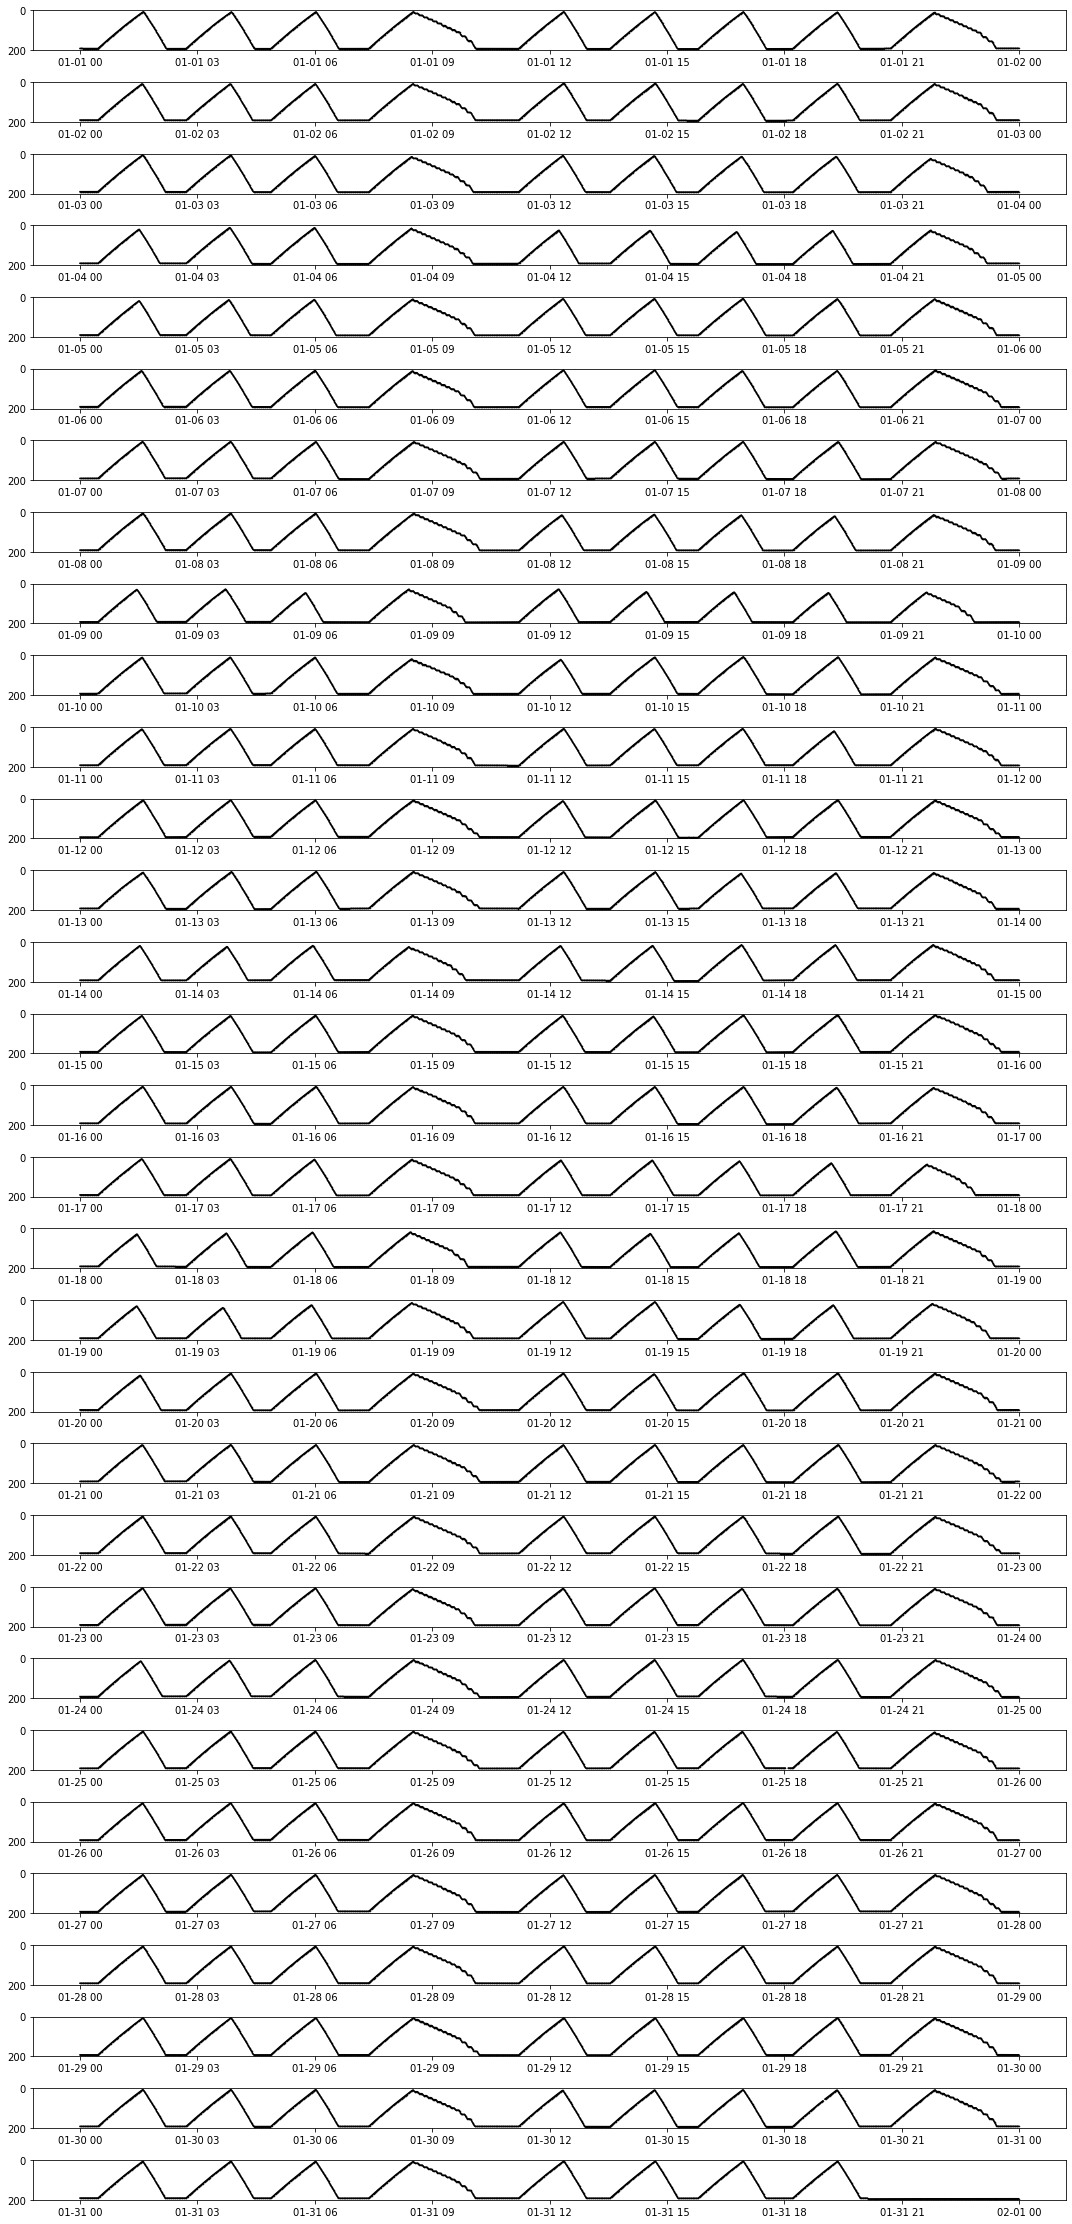

In [8]:
# January 2019 has all but one profile correct (278 / 279 possible). 
#   Missing is the last profile of the month.
# For each given UTC day: Profiles 4 and 9 are pH profiles.
#   Could use time window criteria: Hour on [6, 10] and [19, 23].

fig, axs = plt.subplots(31, 1, figsize=(15,31), tight_layout=True)
ds_CTD = xr.open_dataset("./data/rca/ctd/osb_ctd_jan2019_1min.nc")

for i in range(31):
    daystring = str(i+1) if i > 8 else '0' + str(i+1)
    time0, time1 = dt64('2019-01-' + daystring + 'T00:00:00'), dt64('2019-01-' + daystring + 'T23:59:59')
    ds = ds_CTD.sel(time=slice(time0, time1))
    axs[i].plot(ds.time, ds.seawater_pressure, marker='.', markersize=1., color='k')
    axs[i].set(ylim = (200., 0.))

print('...January 2019 OSB depth profiles...')

## Expanding to the full shallow profiler dataset


### Review "dimensions" of shallow profiler data. 


* There are three sites, abbreviated here **axb**, **oos** and **osb**
* There are seven years of data collection possible, 2015 ... 2021
* There are up to 16 different "level 1+" data products considered
    * backscatter
    * cdom
    * chlora
    * density
    * dissolved oxygen
    * nitrate
    * par
    * pco2
    * pH
    * pressure
    * salinity
    * spectral irradiance
    * temperature
    * velocity east
    * velocity north
    * velocity up
* There are three types of profiler behavior: ascend, descend, rest
    * Nine profiles per day
    * Noon and midnight profiles feature stabilization stops on descent
    * There are profiles during day and night 
    * There is seasonality
* There is a platform with a set of related instruments
    * backscatter
    * cdom
    * chlora
    * density
    * dissolved oxygen version 1
    * dissolved oxygen version 2
    * dissolved oxygen version 3
    * ph
    * pressure
    * salinity
    * temperature
* There are other higher-rate instruments (profiler and platform)
    * spectrophotometer


### Check data availability for the three shallow profiler sites

Vertical axis is depth in meters, horizontal is time.

[(-220.0, 0.0), (16314.0, 19052.0), Text(0.5, 1.0, 'Oregon Slope Base')]

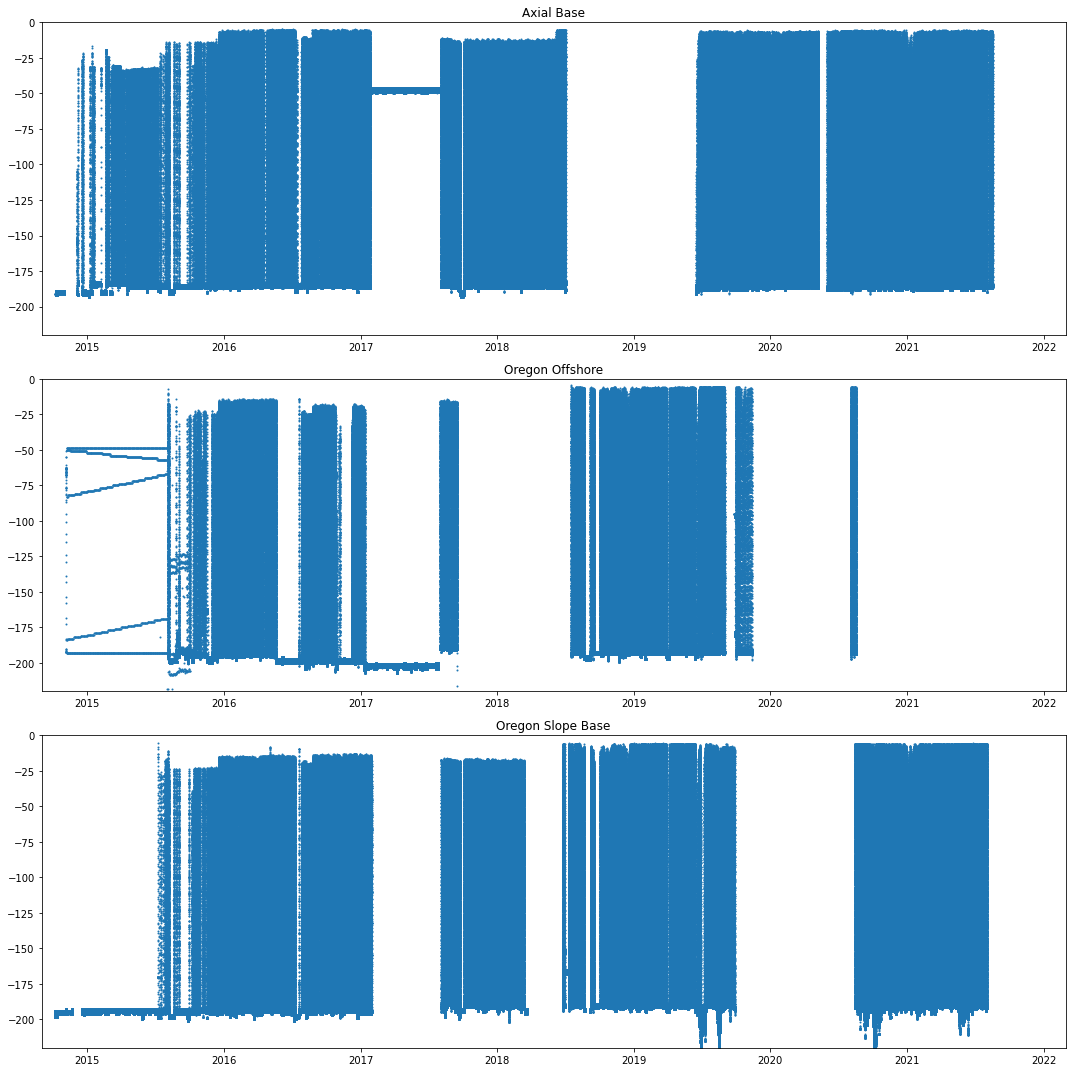

In [10]:
# This will be all of Axial Base
fig, axs = plt.subplots(3,1,figsize=(15,15), tight_layout=True)
t0, t1 = dt64('2014-09-01'), dt64('2022-03-01')
ds = xr.open_dataset('/mnt/d/data/data_explorer_1Min/axb/profiler/axb_profiler_pressure_1Min.nc')
axs[0].scatter(ds.time, ds.z, s=1.)      # for plot use: marker='.', markersize=1., color='k')
axs[0].set(ylim = (-220., 0.), xlim = (t0, t1), title='Axial Base')

ds = xr.open_dataset('/mnt/d/data/data_explorer_1Min/oos/profiler/oos_profiler_pressure_1Min.nc')
axs[1].scatter(ds.time, ds.z, s=1.)      # for plot use: marker='.', markersize=1., color='k')
axs[1].set(ylim = (-220., 0.), xlim = (t0, t1), title='Oregon Offshore')

ds = xr.open_dataset('/mnt/d/data/data_explorer_1Min/osb/profiler/osb_profiler_pressure_1Min.nc')
axs[2].scatter(ds.time, ds.z, s=1.)      # for plot use: marker='.', markersize=1., color='k')
axs[2].set(ylim = (-220., 0.), xlim = (t0, t1), title='Oregon Slope Base')

### Store profile listings as CSV files

#### Uses the pressure versus time data shown above

The next cell generates CSV files listing "self-consistent" profiles consisting of 

```
Ascent start - Ascent End = Descent Start - Descent End = Rest Start - Rest End
```

Each year is considered independently (7 total) and there are three sites. As Oregon Offshore
did not operate in 2021 there are 20 (not 21) result files.


In [5]:
# Uncomment to run: Takes a few minutes to complete
# ProfileWriter(['axb', 'oos', 'osb'], 2015, 2021)





working on site axb year 2015
there are 1118 ascent starts
there are 1127 descent starts
there are 1316 rest starts: now culling extras
there are 1118 ascent starts
there are 1127 descent starts
there are 1117 rest starts
causal error counts: 1110 0 0
1118 1127 1117
1118 1127 1117 interval starts
1127 1117 1117 interval ends
found 1107 good ascents
found 1096 good descents
found 607 good rests
no doubling of profile ascent starts found
arrived at 575 good candidate profiles
after removing 11 due to time slip error
transitions are self-consistent
of 365 days, 39 have nine profiles as desired
...and 2 had more than nine profiles
doy 301 had more than nine profiles
doy 308 had more than nine profiles




working on site axb year 2016
there are 2939 ascent starts
there are 2941 descent starts
there are 4264 rest starts: now culling extras
there are 2939 ascent starts
there are 2941 descent starts
there are 2941 rest starts
causal error counts: 1494 889 889
2939 2941 2941
2939 2941 2941





working on site osb year 2015
there are 659 ascent starts
there are 661 descent starts
there are 860 rest starts: now culling extras
there are 659 ascent starts
there are 661 descent starts
there are 658 rest starts
causal error counts: 654 0 0
659 661 658
659 661 658 interval starts
661 658 658 interval ends
found 658 good ascents
found 644 good descents
found 596 good rests
no doubling of profile ascent starts found
arrived at 573 good candidate profiles
after removing 6 due to time slip error
transitions are self-consistent
of 365 days, 45 have nine profiles as desired
...and 0 had more than nine profiles




working on site osb year 2016
there are 2946 ascent starts
there are 2955 descent starts
there are 4265 rest starts: now culling extras
there are 2946 ascent starts
there are 2955 descent starts
there are 2948 rest starts
causal error counts: 2652 0 0
2946 2955 2948
2946 2955 2948 interval starts
2955 2948 2945 interval ends
found 2944 good ascents
found 2935 good descents


### Examine one of the site + year profile records

In [14]:
df = ReadProfiles(os.getcwd() + '/../Profiles/osb2017.csv')
print('Example: Descent end time, table row 2:', df['descent_end'][2])
print()
print()
df

Example: Descent end time, table row 2: 2017-01-01 06:28:00




,ascent_start,ascent_end,descent_start,descent_end,rest_start,rest_end
0,2017-01-01 00:27:00,2017-01-01 01:31:00,2017-01-01 01:31:00,2017-01-01 02:05:00,2017-01-01 02:05:00,2017-01-01 02:42:00
1,2017-01-01 02:42:00,2017-01-01 03:46:00,2017-01-01 03:46:00,2017-01-01 04:20:00,2017-01-01 04:20:00,2017-01-01 04:52:00
2,2017-01-01 04:52:00,2017-01-01 05:56:00,2017-01-01 05:56:00,2017-01-01 06:28:00,2017-01-01 06:28:00,2017-01-01 07:22:00
3,2017-01-01 07:22:00,2017-01-01 08:26:00,2017-01-01 08:26:00,2017-01-01 09:55:00,2017-01-01 09:55:00,2017-01-01 11:12:00
4,2017-01-01 11:12:00,2017-01-01 12:16:00,2017-01-01 12:16:00,2017-01-01 12:50:00,2017-01-01 12:50:00,2017-01-01 13:32:00
...,...,...,...,...,...,...
1389,2017-12-31 07:22:00,2017-12-31 08:26:00,2017-12-31 08:26:00,2017-12-31 09:55:00,2017-12-31 09:55:00,2017-12-31 11:12:00
1390,2017-12-31 11:12:00,2017-12-31 12:16:00,2017-12-31 12:16:00,2017-12-31 12:50:00,2017-12-31 12:50:00,2017-12-31 13:32:00
1391,2017-12-31 13:32:00,2017-12-31 14:36:00,2017-12-31 14:36:00,2017-12-31 15:10:00,2017-12-31 15:10:00,2017-12-31 15:47:00
1392,2017-12-31 15:47:00,2017-12-31 16:51:00,2017-12-31 16:51:00,2017-12-31 17:25:00,2017-12-31 17:25:00,2017-12-31 18:12:00
